In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

In [27]:
def get_dataset_and_filter_outliers(device, dataset):
    configuration = tflscripts.read_configuration()
    sensor_streams = [
        'MICROPHONE_fft',
        'ACCEL_fft',
        'EMI',
        'MAGNETO',
        'GEYE',
        'COLOR',
        'TEMPERATURE',
        'IRMOTION',
        'RSSI',
        'HUMIDITY',
        'BAROMETER'
    ]

    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    activities = [
        "Dishes",
        "Microwave",
        "Coffee",
        "Null",
#         "Faucet",
        "Kettle",
#         "Phone ringing",
        "Chopping food",
        "Conversation",
        "Eating popcorn",
#         "Microwave door opened",
#         "Microwave door closed",
#         "Cupboard door opened",
#         "Cupboard door closed",
#         "Microwave button press",
#         "Taking ice",
#         "Making popcorn in microwave",
#         "Room lights off",
        "Knocking",
#         "Frequency sweep",
        "Phone vibrating"
    ]
    activities_i = [configuration['activities'].index(a) for a in activities]

    value_columns = df.filter(regex='|'.join(sensor_streams)).columns

    df = df.loc[df.label.isin(activities_i)]

    null_df = df.loc[df.label == configuration['activities'].index('Null')]
    null_mean = null_df[value_columns].mean()
    null_std = null_df[value_columns].std()
    anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)

    df['anomalies'] = anomalies
    df = df.loc[df.anomalies > 60]

    outliers = {}

    for sensor_stream in sensor_streams:
        null_df = df.loc[df.label == configuration['activities'].index('Null')]
        value_columns = null_df.filter(regex=sensor_stream).columns

#         clf = IsolationForest(contamination=0.01)
#         clf.fit(null_df)
 
        null_mean = null_df[value_columns].mean()
        null_std = null_df[value_columns].std()
        anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)

#         other_df = df.loc[df.label != configuration['activities'].index('Null')]
        anomalies.loc[anomalies == np.inf] = 0

        outliers[sensor_stream] = anomalies

#         clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
#         clf.fit(null_df)

#         outliers[sensor_stream + '_svm'] = clf.predict(df.filter(regex=sensor_stream))

#         decisions = [x[0] for x in clf.decision_function(df.filter(regex=sensor_stream))]
#         outliers[sensor_stream + '_decisions'] = decisions

#     value_columns = df.filter(regex='|'.join(sensor_streams)).columns
#     df[value_columns] = StandardScaler().fit_transform(df[value_columns])

    return StandardScaler().fit_transform(pd.DataFrame(outliers)), df.label.values

In [28]:
x_train, y_train = get_dataset_and_filter_outliers('128.237.254.195', 'synergy-final-iter1')
x_test, y_test = get_dataset_and_filter_outliers('128.237.248.186', 'synergy-final-iter2')

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

0.238625

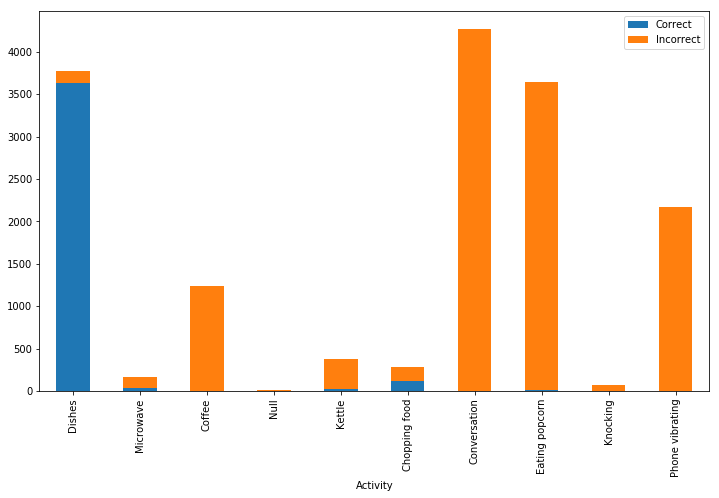

In [29]:
results = []
configuration = tflscripts.read_configuration()
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])
results = pd.DataFrame(results)
results.columns = ['Activity', 'Correct', 'Incorrect']
results = results.set_index('Activity')
results.plot.bar(stacked=True)

In [38]:
x, y = get_dataset_and_filter_outliers('128.237.247.134', 'scott-final-iter1')

train_test_split = np.random.rand(len(x)) < 0.70
x_train = x[train_test_split]
y_train = y[train_test_split]
x_test = x[~train_test_split]
y_test = y[~train_test_split]

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', RandomForestClassifier())
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

0.97917427840701499

In [221]:
configuration = tflscripts.read_configuration()

dataset_path = '../datasets/scott-final-iter1-complete/'
df = pd.read_pickle(dataset_path + '128.237.247.134.p')
value_columns = df.filter(regex='^(?!label)').columns

In [222]:
null_df = df.loc[df.label == configuration['activities'].index('Null')]
null_mean = null_df[value_columns].mean()
null_std = null_df[value_columns].std()

In [223]:
all_anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)

In [9]:
x_train

,ACCEL_fft,BAROMETER,COLOR,EMI,GEYE,HUMIDITY,IRMOTION,MAGNETO,MICROPHONE_fft,RSSI,TEMPERATURE
i_index,,,,,,,,,,,
0,9.736239,1.780361,14.919994,1.779343,24.078146,1.462924,6.424370,3.070270,8.570070,2.060506,1.618396
1,9.725456,1.902991,10.749184,1.779343,22.747042,1.462924,7.925618,3.006615,8.801243,0.930867,7.097948
2,9.725456,1.902991,10.749184,1.779343,21.503806,1.462924,3.922835,3.195830,8.801243,0.930867,7.097948
3,9.738923,1.902991,10.453346,1.779343,21.503806,1.462924,3.922835,3.195830,6.427090,0.992571,7.097754
4,9.712987,1.902991,9.540281,1.779343,25.026561,1.462924,3.366047,3.629441,10.478503,1.536337,7.111135
5,9.716282,1.902991,9.540281,1.779343,22.058787,1.462924,1.512162,3.629441,8.192971,1.536337,1.572105
7,9.725896,2.953745,4.669279,1.779343,21.528795,1.462924,2.968255,5.367216,7.572883,1.536337,1.572105
8,9.725896,2.953745,1.887285,1.779343,20.570170,1.462924,4.149766,5.156959,7.572883,1.536451,1.572105
9,9.726811,1.780361,1.887285,1.779343,20.570170,1.462924,4.149766,5.156959,9.502862,2.352211,1.572105
